# Session 2:  MsPASS Generalized Headers (Metadata container)
## Discussion:  Headers
Discussion will be driven by a related set of powerpoint slides.


## Overview and learning objectives
In this session our aim is to help you understand the following fundamental concepts in MsPASS:
- Generalized headers
- The MsPASS database handle
- MongoDB *collections* and *documents*.  *Collection*==*relation* and *document*==*tuple*
- A MongoDB document can be mapped into a python dictionary (*dict* container)
- In MongoDB "normalization" is comparable to a relational database join
- Performance in MongoDB requires an index unless the collection is small
- Default index is ObjectID, but others can be defined easily
- MsPASS uses a default schema that has options for enforcing modest to rigid rules on data types
- MsPASS has two data object:  *TimeSeries*=single channel data, *Seismogram*=three-component data
- Data arrays can be indexed in python as in C or Fortran, but more efficiently handled with compiled algorithms like numpy and scipy
- MsPASS were designed to capture key data concepts (e.g. generic time series concepts, metadata, etc.) independent of any format

## Database handles and miniseed input
This tutorial assumes you have already completed the session 1 overview tutorial.  There we had two options for building the tutorial data set:  (1) download a tar file we supplied, and (2) acquiring the same data through FDSN web services.  In either case, for this tutorial you should verify you have a directory/folder in the directory where you launched jupyter called "./wf".  If you tried the FDSN download method, the timing data of that operation should convince you that web service input to a workflow is currently a bad idea.   In most cases, you will likely want to start processing with input from miniseed files like that you should now have spinning on your machine.  

Reading directly from miniseed is a useful feature, but since most of the students in this course are likely to have some experience with miniseed the hope is the header namespace this creates will be familiar ground. We will also be using the paradigm of one file per channel of data that SAC users are familiar with.   We do that for the educational benefit.  We presume it is familiar ground to most students and helps clarify a key relationship of what metadata belong to which signal. A noteworth point, however, is we consider the model of one file per signal an abomination that needs to be exorcised from data management dogma because it creates horrible performance problems on HPC systems. We are using that model here only to aid your understanding.  Normal practice with miniseed files should be to concatenate sets of files into logical groupings like event files or day volumes.

Our first step is to read the set of miniseed files we created in session1.  First, let's just use a python way to look into that directory:

In [1]:
import os
with os.scandir('./wf') as entries:
    for entry in entries:
        print(entry.name)

._shortcourse_0.mseed
._shortcourse_1.mseed
._shortcourse_10.mseed
._shortcourse_100.mseed
._shortcourse_1000.mseed
._shortcourse_1001.mseed
._shortcourse_1002.mseed
._shortcourse_1003.mseed
._shortcourse_1004.mseed
._shortcourse_1005.mseed
._shortcourse_1006.mseed
._shortcourse_1007.mseed
._shortcourse_1008.mseed
._shortcourse_1009.mseed
._shortcourse_101.mseed
._shortcourse_1010.mseed
._shortcourse_1011.mseed
._shortcourse_1012.mseed
._shortcourse_1013.mseed
._shortcourse_1014.mseed
._shortcourse_1015.mseed
._shortcourse_1016.mseed
._shortcourse_1017.mseed
._shortcourse_1018.mseed
._shortcourse_1019.mseed
._shortcourse_102.mseed
._shortcourse_1020.mseed
._shortcourse_1021.mseed
._shortcourse_1022.mseed
._shortcourse_1023.mseed
._shortcourse_1024.mseed
._shortcourse_1025.mseed
._shortcourse_1026.mseed
._shortcourse_1027.mseed
._shortcourse_1028.mseed
._shortcourse_1029.mseed
._shortcourse_103.mseed
._shortcourse_1030.mseed
._shortcourse_1031.mseed
._shortcourse_1032.mseed
._shortcours

shortcourse_1068.mseed
shortcourse_1069.mseed
shortcourse_107.mseed
shortcourse_1070.mseed
shortcourse_1071.mseed
shortcourse_1072.mseed
shortcourse_1073.mseed
shortcourse_1074.mseed
shortcourse_1075.mseed
shortcourse_1076.mseed
shortcourse_1077.mseed
shortcourse_1078.mseed
shortcourse_1079.mseed
shortcourse_108.mseed
shortcourse_1080.mseed
shortcourse_1081.mseed
shortcourse_1082.mseed
shortcourse_1083.mseed
shortcourse_1084.mseed
shortcourse_1085.mseed
shortcourse_1086.mseed
shortcourse_1087.mseed
shortcourse_1088.mseed
shortcourse_1089.mseed
shortcourse_109.mseed
shortcourse_1090.mseed
shortcourse_1091.mseed
shortcourse_1092.mseed
shortcourse_1093.mseed
shortcourse_1094.mseed
shortcourse_1095.mseed
shortcourse_1096.mseed
shortcourse_1097.mseed
shortcourse_1098.mseed
shortcourse_1099.mseed
shortcourse_11.mseed
shortcourse_110.mseed
shortcourse_1100.mseed
shortcourse_1101.mseed
shortcourse_1102.mseed
shortcourse_1103.mseed
shortcourse_1104.mseed
shortcourse_1105.mseed
shortcourse_1106.

shortcourse_77.mseed
shortcourse_770.mseed
shortcourse_771.mseed
shortcourse_772.mseed
shortcourse_773.mseed
shortcourse_774.mseed
shortcourse_775.mseed
shortcourse_776.mseed
shortcourse_777.mseed
shortcourse_778.mseed
shortcourse_779.mseed
shortcourse_78.mseed
shortcourse_780.mseed
shortcourse_781.mseed
shortcourse_782.mseed
shortcourse_783.mseed
shortcourse_784.mseed
shortcourse_785.mseed
shortcourse_786.mseed
shortcourse_787.mseed
shortcourse_788.mseed
shortcourse_789.mseed
shortcourse_79.mseed
shortcourse_790.mseed
shortcourse_791.mseed
shortcourse_792.mseed
shortcourse_793.mseed
shortcourse_794.mseed
shortcourse_795.mseed
shortcourse_796.mseed
shortcourse_797.mseed
shortcourse_798.mseed
shortcourse_799.mseed
shortcourse_8.mseed
shortcourse_80.mseed
shortcourse_800.mseed
shortcourse_801.mseed
shortcourse_802.mseed
shortcourse_803.mseed
shortcourse_804.mseed
shortcourse_805.mseed
shortcourse_806.mseed
shortcourse_807.mseed
shortcourse_808.mseed
shortcourse_809.mseed
shortcourse_81.m

The names are meaningless, but let's now build an index for this set of files and store them in our database.  To do that we first have to build the MsPASS handle used to access the data.  Variations of the following incantation will normally appear at the top of any MsPASS job script:

In [2]:
from mspasspy.db.client import DBClient
from mspasspy.db.database import Database
dbclient=DBClient()
dbh=Database(dbclient,'shortcourse')

There are two things created here that are important to understand:
1.  *dbclient* is an instance of a communication handle created to interact with MongoDB.  It is a minor variant of a pymongo class called *Client*.  (For those familiar with object oriented programming *DBClient* is a subclass/child of *Client*.).  It can be thought of as a top level handle for the entire database system.  It is normally created once and referenced only in calls like the last line of the box above.
2.  *dbh* is an instance of the MsPASS *Database* class.  *dbh* is a handle that we will use to manipulate a particular database, which in this case we called "shortcourse".  We will get more into the weeds of MongoDB later, but for now think of this as an abstract handle we use to interact with the database. 

With that our next step is to build an index to each of the files in "./wf".   

In [3]:
# This line is not normal. We do it here because we previously created 
# a wf_miniseed collection in session 1.  This does nothing if that 
# collection does not exists, but if it does it clears it so we can 
# all start on the same page
dbh.drop_collection('wf_miniseed')
with os.scandir('./wf') as entries:
    for entry in entries:
        if entry.is_file():
            filename='./wf'+'/'+entry.name
            dbh.index_mseed_file(filename)

To get a first notion of what that did, consider the output created by this incantation:

In [4]:
n=dbh.wf_miniseed.count_documents({})
print('Number of documents in wf_miniseed collection=',n)

Number of documents in wf_miniseed collection= 1287


## MongoDB documents and collections
If you run a shell and run ls on the wf directory you will find that we started with 1287 miniseed files.  Hence, for this example we created one "document" in our database for each file.   We'll dig into the syntax for *count_documents* and the related *find* function of pymongo in a moment, but for now let's have a look at what these "documents" contain.  To do this we are going to make a prettier print than the default using a nice json utility provided through MongoDB called json_util:

In [5]:
from bson import json_util
cursor=dbh.wf_miniseed.find({}).limit(3)  # this means select the first 3 documents
for doc in cursor:
    print(json_util.dumps(doc,indent=5))


{
     "_id": {
          "$oid": "610b0db041137be366da3bf8"
     },
     "sta": "034A",
     "net": "TA",
     "chan": "BHE",
     "sampling_rate": 40.0,
     "delta": 0.025,
     "starttime": 1302187287.1,
     "last_packet_time": 1302188727.725,
     "foff": 0,
     "nbytes": 53248,
     "storage_mode": "file",
     "format": "mseed",
     "dir": "/home",
     "dfile": "./wf/shortcourse_0.mseed"
}
{
     "_id": {
          "$oid": "610b0db041137be366da3bf9"
     },
     "sta": "034A",
     "net": "TA",
     "chan": "BHN",
     "sampling_rate": 40.0,
     "delta": 0.025,
     "starttime": 1302187287.1,
     "last_packet_time": 1302188710.875,
     "foff": 0,
     "nbytes": 53248,
     "storage_mode": "file",
     "format": "mseed",
     "dir": "/home",
     "dfile": "./wf/shortcourse_1.mseed"
}
{
     "_id": {
          "$oid": "610b0db041137be366da3bfa"
     },
     "sta": "109C",
     "net": "TA",
     "chan": "BHN",
     "sampling_rate": 40.0,
     "delta": 0.025,
     "starttime"

Some key points to learn from this output:
- A MongoDB document is made up only of a set of name-value pairs
- The names (keys) are like header name fields, but less restictive
- The "values" in the name-value pairs can be almost anything (examples here are int, float, and string plus an obscure thing we will visit momentarily with the key "_id")
- Those familiar with miniseed can likely guess what most of these attributes are.  *Discuss*
- A "document" looks and acts like (it isn't actually, but that is an advanced topic) a python dictionary (dict)
- A "collection" in MongoDB is a set of "documents" that are grouped under a particular name.  In our example so far we have used the name "wf_miniseed".  

Because MongoDB documents are a container that acts like a python dictionary it is pretty easy to write a simple report generator showing only data associated with a particular key in tabular form.  Here is a simple example that prints only some data for the first 5 documents.

In [6]:
from obspy import UTCDateTime
print('counter net sta chan starttime samplerate')
cursor=dbh.wf_miniseed.find({}).limit(3)
i=0
for doc in cursor:
    net=doc['net']
    sta=doc['sta']
    chan=doc['chan']
    stime=doc['starttime']
    samprate=doc['sampling_rate']
    print(i,net,sta,chan,UTCDateTime(stime),samprate)
    i+=1

counter net sta chan starttime samplerate
0 TA 034A BHE 2011-04-07T14:41:27.100000Z 40.0
1 TA 034A BHN 2011-04-07T14:41:27.100000Z 40.0
2 TA 109C BHN 2011-04-07T14:41:27.119500Z 40.0


The point of that short script was that you can access a member of a document with the key using python dict syntax.   

*Exercises:*
Do one or more of the following in the code box.  Post questions in the chat.  We will reconvene and discuss peopele's experience in about 10 minutes.
1.  Modify the json_util dumps box to display the first 3 documents in the "wf_Seismogram" collection.  What differences do you see?
2.  Modify the report generator box immediately above to add on or more additionl attributes to the report.

## MsPASS abstraction of data reading
An important design goal of MsPASS was making basic reads and writes of data objects with a database handle (*dbh* we created above and used in the boxes above) simple.   Readers are driven by "documents" in a set of collection we call "wf collections" in our user manual.  This example that produces an output comparable to the example above: 

In [7]:
cursor=dbh.wf_miniseed.find({}).limit(3)
i=0
for doc in cursor:
    d=dbh.read_data(doc,collection='wf_miniseed')
    print('Metadata for data object number ',i)
    print(d)
    i+=1

Metadata for data object number  0
{'_id': ObjectId('610b0db041137be366da3bf8'), 'chan': 'BHE', 'delta': 0.025000, 'dfile': './wf/shortcourse_0.mseed', 'dir': '/home', 'foff': 0, 'format': 'mseed', 'last_packet_time': 1302188727.725000, 'nbytes': 53248, 'net': 'TA', 'npts': 57625, 'sampling_rate': 40.000000, 'sta': '034A', 'starttime': 1302187287.100000, 'storage_mode': 'file'}
Metadata for data object number  1
{'_id': ObjectId('610b0db041137be366da3bf9'), 'chan': 'BHN', 'delta': 0.025000, 'dfile': './wf/shortcourse_1.mseed', 'dir': '/home', 'foff': 0, 'format': 'mseed', 'last_packet_time': 1302188710.875000, 'nbytes': 53248, 'net': 'TA', 'npts': 56951, 'sampling_rate': 40.000000, 'sta': '034A', 'starttime': 1302187287.100000, 'storage_mode': 'file'}
Metadata for data object number  2
{'_id': ObjectId('610b0db041137be366da3bfa'), 'chan': 'BHN', 'delta': 0.025000, 'dfile': './wf/shortcourse_10.mseed', 'dir': '/home', 'foff': 0, 'format': 'mseed', 'last_packet_time': 1302188763.694500, 

Our print line calls the output *Metadata*.  That is the name we give it, but you might find it helpful to think of it as a generalized header.  (Obspy user's may recognize this concept in the *stats* attribute of the obpsy Trace container.)  Print just shows the metadata, but you should realize that the symbol *d* now contains a single channel of seismic data (the last one listed in this case; the Z channel of TA station E26A).  To show that let's plot it:

First this is what python says is the type of d:   <class 'mspasspy.ccore.seismic.TimeSeries'>


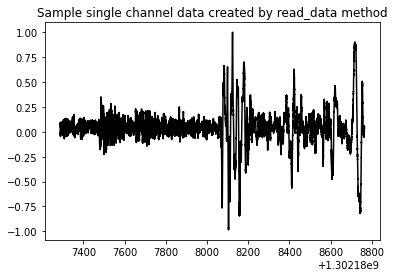

In [8]:
print('First this is what python says is the type of d:  ',type(d))
from mspasspy.graphics import SeismicPlotter
plotter=SeismicPlotter(normalize=True)
plotter.change_style('wt')
plotter.title='Sample single channel data created by read_data method'
plotter.plot(d)

There are currently four data objects supported natively in MsPASS:
1.  A *TimeSeries* defines a single channel of data like the example we just plotted.
2.  A *Seismogram* defines an abstraction of three-component data that has native methods for handling some common operations on such data (e.g. rotation of coordinates to radial, tranverse, and vertical).  
3.  A *TimeSeriesEnsemble* defines a bundle of *TimeSeries* objects.   In reflection processing it would be called a "gather".
4.  A *SeismogramEnsemble* defines a bundle of *Seismogram* objects.   It has a completely parallel data structure to a *TimeSeriesEnsemble*, but the *member* attribute contains *Seismogram* objects intead of *TimeSeries* objects. 

For more details about the concepts behind these data objects see appropriate sections of the User's Manual found at https://www.mspass.org/. 

There are database readers and writers that make loading from and saving to the database as simple as possible.  We saw a reader that creates *TimeSeries* data from miniseed files, but here is another example that reads a *TimeSeriesEnsemble* defined for this example by all the data indexed in our wf_miniseed collection:

In [9]:
# if you have a memory fault here, change to a variant of this:
#cursor=dbh.wf_miniseed.find({}).limit(100)
cursor=dbh.wf_miniseed.find({})
ensemble=dbh.read_ensemble_data(cursor,collection='wf_miniseed')
print('python calls the type of the result this->',type(ensemble))
print('The symbol member contains the components of the ensemble')
print('The number of members in this ensemble=',len(ensemble.member))
print('Type of a component of the member vector=',type(ensemble.member[0]))

python calls the type of the result this-> <class 'mspasspy.ccore.seismic.TimeSeriesEnsemble'>
The symbol member contains the components of the ensemble
The number of members in this ensemble= 1287
Type of a component of the member vector= <class 'mspasspy.ccore.seismic.TimeSeries'>


Noting we didn't try to plot that data because of number of data in the ensemble.

Finally, here is an example of reading and plotting a single *Seismogram* object that was created and saved in session 1:

This is what python says is the type of d:  <class 'mspasspy.ccore.seismic.Seismogram'>


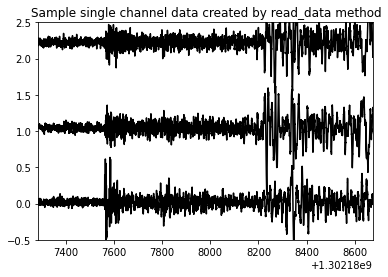

In [10]:
query={}
doc=dbh.wf_Seismogram.find_one(query)
d=dbh.read_data(doc,collection='wf_Seismogram')
print('This is what python says is the type of d: ',type(d))
plotter.plot(d)

Saving this data after doing something is equally easy.  In the next block we will apply a short-period filter to the above data, plot it, and then save it back to our database.

save_data returned this:  {'_id': ObjectId('610b1bc441137be366da4106'), 'calib': 1.000000, 'cardinal': False, 'chan': 'E', 'data_tag': 'rawsample', 'delta': 0.025000, 'dfile': './wf/shortcourse_8.mseed', 'dir': '/home', 'endtime': 1302188676.225000, 'foff': 0, 'format': 'mseed', 'gridfs_id': ObjectId('610b1bc441137be366da40ff'), 'history_object_id': '7d0c147c-6e7f-4faf-a3e1-558617dd7578', 'loc': '', 'net': '', 'npts': 55566, 'orthogonal': False, 'processing': ["ObsPy 1.2.2: filter(options={'freqmax': 2.0, 'freqmin': 0.8}::type='bandpass')"], 'sampling_rate': 40.000000, 'site_id': ObjectId('610b0baad9e953b77ae54c05'), 'source_id': ObjectId('610b0ba1d9e953b77ae54bfe'), 'sta': '', 'starttime': 1302187287.100000, 'storage_mode': 'gridfs', 'time_standard': 'UTC', 'tmatrix': [0.0, 0.0, 1.0, 0.00872653549840032, 0.9999619230641711, 2.6484540326036093e-14, 0.9999619230641713, -0.008726535498373787, 2.6484540326036093e-14], 'utc_convertible': True}


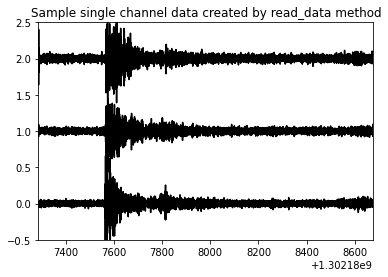

In [11]:
from mspasspy.algorithms.signals import filter
filter(d,type='bandpass',freqmax=2.0,freqmin=0.8)
plotter.plot(d)
ret=dbh.save_data(d,data_tag='spfiltered_example')
print('save_data returned this: ',ret)

That is about as simple as it could be.  The only option we used in this case was the *data_tag* option.   A *data_tag* is used as a simple mechanism to identify a save done at a particular stage of processing.   To see what we mean by that consider the following small script that counts the number of data stored without such a tag and the number stored with the one we just used:

In [12]:
ntotal=dbh.wf_Seismogram.count_documents({})
print('Total number of Seismogram objects currently stored=',ntotal)
query={'data_tag' : 'spfiltered_example'}
nsp=dbh.wf_Seismogram.count_documents({'data_tag' : 'spfiltered_example'}) 
nnull=dbh.wf_Seismogram.count_documents({'data_tag' : {'$exists' : False}})
print('Number of data with tag spfiltered tag=',nsp)
print('Number of data with no tag or another tag=',nnull)

Total number of Seismogram objects currently stored= 104
Number of data with tag spfiltered tag= 1
Number of data with no tag or another tag= 0


The same Database method can be used for saving and reading *TimeSeries* objects as illustrated elsewhere in notebooks used in this tutorial    There are also readers and writers for ensembles that have the names *read_ensemble_data* and *save_ensemble_data* respectively.  They are described in MsPASS User's manual python API.  Because of time limits we leave it as an exercise for the student to apply them.  

In the above we used some incantations passed to MongoDB.   Before explaining that magic we need to discuss some basic concepts of MongoDB and how it is used in MsPASS.

## MongoDB Concepts
First a caveat.  MongoDB is itself a complex piece of modern software.   As a widely used, open-source package there are numerous online tutorials and several books to teach you how to use the software.  MongoDB is NOT a relational database, but one of a range of what are sometimes called "noSQL database" systems.   Other noSQL databases have been experimented with in the geosciences in recent years, but to our knowledge MsPASS is the first application of the type of database that is implemented in MongoDB.  MongoDB is an implementation of a class of databases called a "document database".  Students familiar with relational databases may find MongoDB confusing while we suspect those without that training will find it actually easier to use than any relational system with which we are familiar.  We cannot cover all the things you will need to know about MongoDB to use MsPASS effectively, but stress the documentation is so extensive you should have no problem teaching yourself everything you need to know about it for processing data with MsPASS.  

Fundamental concepts you will need to understand to be able to use MsPASS effectively are the following:
* Above we gave an introduction to the idea of a *collection* and *document*.   We need to expand that basic understanding, especially defining what "collections" are defined by default in MsPASS.  In particular, MsPASS uses a set of "normalization" collections for storage efficiency.  
* A relational database depends heavily upon a schema to be at all functional.  MongoDB can be run without any schema restriction, but doing so is a bit if an invitation to disaster.   The MsPASS Database handle has an implict set of loose schema restrictions we will introduce here.  We note the schema can be altered by the user, but that topic will not be covered in this course for lack of time.
* We saw a few examples of queries above. We will cover some basics to help you get started.
* MongoDB makes extensive use of indices and depends upon them for efficiency.
* Data storage concepts we use in MsPASS are a mix of pure MongoDB stores and file system stores.  Understanding where your data live is fundamental for a long list of reasons.

The sections below can, we hope, help you understand these fundamental concepts.  


### Documents, collections, and schema basics
Above you should have learned that a *document* is made up of a set of name-value pairs and a *collection* is a set (collection) of documents.  For those familiar with relational databases we reiterate that a *document* is equivalent to a single tuple in a relation (table) and a *collection* is roughly equivalent to a single relation (table).  For the novice, we mote that a *schema* in a relational database defines all the table/relation and attribute names and how the tables/relations are expected to be linked together (join keys). MongoDB actually has no such rules at all.  It only understands that a document is a bunch of name-value pairs and the only real restriction is a key in a document can be used only once in that document. For a system like MsPASS there has to be some agreement on what concept the attribute a particular key reference is. (e.g. 'time' is a completely ambiguous name by itself and could be used to mean a long list of concepts in seismology without a qualification.)  A schema for MongoDB has much in common with that of a relational database.   The primary things it needs to define are:
- An agreed on set of names for collections.   This is an exact parallel to table/relation names in a relational database.
- The keys used in key-value pairs need understood as linked to some concept we agree on.
- The value associated with each key should be consistent with the concept it defines and be at least convertible to that type (e.g. npts is the number of samples in a stored signal and is required to be an integer). 

An important, but more advanced topic, that we don't have time to cover in detail today is that the *Database* handle in MsPASS can be set to one of three levels of schema enforcement in reads and writes via the *mode* argument:
1.  Reads and writes with mode='promiscuous' bypass all safeties and all attributes are just dumped on writes and loaded on save with no type checking or key validation.  This is the default mode for reads and writes to avoid unintentional loss of data, but it intrinsically dangerous.
2.  Reads and writes with mode='cautious', check that all keys used are defined and on writes validates types and tries to fix any type errors. 
3.  The mode='pedantic' acts much like 'cautious' except any mismatches of key and type against the schema will cause the datum to be marked dead.

Handling of data marked dead and errors posted to an error log are discussed below, but one of the reasons 'promiscuous' is the default mode is Metadata errors are common and 'cautious' and 'pedantic' can create very large error logs with a large data set containing the same error on every datum.  A related topic we are also skipping today in the interest of time are *verify* and *clean* tools for finding and fixing common problems.   

The Database handle in MsPASS is aware of the following collection names by default:
1.  There are a series of collections that are used to define waveform data.   The names of all of these begin with the string "wf_".  Currently there are three standard names:  (a) *wf_miniseed* (used above) is used to hold an index of raw data stored in the miniseed format; (b) *wf_TimeSeries* is used to data stored as single-channel records; and (c) *wf_Seismogram* is used to stored data prebundled into three components (see example above).  Note the naming convention has natural extension to other raw formats.  e.g. it would be easy to build a reader for segy on sac data that with this convention would be called *wf_segy* and *wf_sac* respectively.   The system was designed so reading other formats like that could be done through the same database reader as wf_miniseed like the example above (e.g. dbh.read_data(collection='wf_sac').  That illustrates a fundamental concept not fully appreciated by most seismologists:  the data is not the format.   We use the wf collections to separate the format from the generic concept we aimed to capture in our TimeSeries and Seismogram objects.  We revisit this issue later in this session.
2. Most raw data requires some basic information about what sensor recorded the data.   In MsPASS these are defined by two collections:  (a) *channel* is used to define receiver properties of *TimeSeries* objects and (b) *site* is used to define receiver properties of *Seismogram* objects.   Note response data is stored only in *channel* collections because response information always refers to a single channel of data.  *site*, in contrast, is largely a place to store geographic location information.
3. Any study using event data needs to associate source information with each datum.  We use the *source* collection to save that metadata. 
4. There are internal collections used by MongoDB and defined under the hood by MsPASS.  Three are defined by MsPASS:  *elog*, *history_global*, and *history_object*.  They are used to store error logs and processing history and will not be covered in detail in this course due to lack of time.  For collections MongoDB uses under the hood we direct you to the MongoDB documentation.  Of particular importance are two collections called *fs.files* and *fs.chunks* that we use to store sample data by default when you run the *save_data* method as we have done multiple times by now.  

In session 1 you actually added documents to most of these collections.  Each of the boxes below show you the basic content (we omit wf_miniseed as we looked at it earlier).  Execute each of these and we will have brief discussion of the content:

In [13]:
collection_list=['wf_TimeSeries','wf_Seismogram','channel','site','source','elog']
for col in collection_list:
    print('First document in collection=',col)
    dbcol=dbh[col]
    doc=dbcol.find_one()
    print(json_util.dumps(doc,indent=5))

First document in collection= wf_TimeSeries
null
First document in collection= wf_Seismogram
{
     "_id": {
          "$oid": "610b0bd4d9e953b77ae55624"
     },
     "orthogonal": false,
     "time_standard": "UTC",
     "starttime": 1302187287.1,
     "delta": 0.025,
     "source_id": {
          "$oid": "610b0ba1d9e953b77ae54bfe"
     },
     "utc_convertible": true,
     "npts": 55566,
     "sampling_rate": 40.0,
     "format": "mseed",
     "site_id": {
          "$oid": "610b0baad9e953b77ae54c05"
     },
     "tmatrix": [
          0.0,
          0.0,
          1.0,
          0.00872653549840032,
          0.9999619230641711,
          2.6484540326036093e-14,
          0.9999619230641713,
          -0.008726535498373787,
          2.6484540326036093e-14
     ],
     "storage_mode": "gridfs",
     "dfile": "./wf/shortcourse_8.mseed",
     "cardinal": false,
     "foff": 0,
     "dir": "/home",
     "gridfs_id": {
          "$oid": "610b0bd4d9e953b77ae5561d"
     },
     "history_o

### Normalization
Any students who have used Antelope or other software based on the standard CSS3.0 relational database schema might notice *site* and *channel* contain information similar to the *site* and *sitechan* (respectively) tables defined by CSS3.0.   We define these collections for the same reason they were defined decades ago in CSS3.0:  for most seismic data there is a one to many relationship between site and the waveform data (i.e. each instrument records many waveforms).   For that reason it is extremely inefficient (for database store that is) to store a copy of station metadata with each waveform in a header structure like SAC or SEGY.  In a relational database a "join" operator is normally used to associate the receiver metadata with each waveform.   MongoDB calls this same basic concept *normalization*.  They use a different name because what is done under the hood is quite different, but conceptually *normalize* and *join* do the same thing.  That is, if we *normalize* the receiver data retreived in a read we will automatically load the receiver metadata.

Source information has similarities and difference with receiver metadata.  We store such data in the *source* collection. Typical content is illustrated above. Some data has a natural link to source information.  A type example is a collection of waveforms from an recent earthquake assembled for a moment tensor inversion.  Other data sets like noise-correlation studies don't care about source information at all except for editing. For that reason a reader should be dogmatic about demanding source data be defined. In fact, all "normalization data" in MsPASS is only loaded if requested.   

To see how that works, let's compare reading the same data with and without normalization with the following example.  Here were normalize Seismogram data with *site* and *source* data we loaded in session1.

In [14]:
doc=dbh.wf_Seismogram.find_one()
d_plain=dbh.read_data(doc,collection='wf_Seismogram')
normalize_list=['site','source']
d_normalized=dbh.read_data(doc,collection='wf_Seismogram',normalize=normalize_list)
# In this loop we compare data loaded with each copy with the MsPASS Metadata container API
# Metadata is also like a python dict, but has a few additional features exploited here
print('key  d_normalized  d_plain')
normalize_keys=list()  # We use this in the next box
for k in d_normalized.keys():
    if d_plain.is_defined(k):   # is_defined is a Metadata method returning a boolean answer
        plain_value=d_plain[k]
    else:
        plain_value='UNDEFINED'
        normalize_keys.append(k)
    print(k,d_normalized[k],plain_value)

    

key  d_normalized  d_plain
orthogonal False False
dfile ./wf/shortcourse_8.mseed ./wf/shortcourse_8.mseed
sta 035Z UNDEFINED
site_lon -98.068298 UNDEFINED
site_id 610b0baad9e953b77ae54c05 610b0baad9e953b77ae54c05
dir /home /home
delta 0.025 0.025
source_lat 38.2513 UNDEFINED
storage_mode gridfs gridfs
npts 55566 55566
source_depth 53.2 UNDEFINED
site_starttime 1262995200.0 UNDEFINED
source_time 1302186764.1 UNDEFINED
net TA UNDEFINED
source_id 610b0ba1d9e953b77ae54bfe 610b0ba1d9e953b77ae54bfe
source_lon 141.7296 UNDEFINED
cardinal False False
starttime 1302187287.1 1302187287.1
data_tag rawsample rawsample
site_endtime 1321833599.0 UNDEFINED
loc  UNDEFINED
tmatrix [0.0, 0.0, 1.0, 0.00872653549840032, 0.9999619230641711, 2.6484540326036093e-14, 0.9999619230641713, -0.008726535498373787, 2.6484540326036093e-14] [0.0, 0.0, 1.0, 0.00872653549840032, 0.9999619230641711, 2.6484540326036093e-14, 0.9999619230641713, -0.008726535498373787, 2.6484540326036093e-14]
foff 0 0
source_magnitude 7.1 U

Let's do a little trick to separate the wheat from the chaff here using the normalize_keys list we saved in the script above:

In [15]:
print('Metadata key-value pairs added by normalization')
normalize_keys.sort()
for k in normalize_keys:
    print(k,d_normalized[k])

Metadata key-value pairs added by normalization
loc 
net TA
site_elev 0.019
site_endtime 1321833599.0
site_lat 26.462999
site_lon -98.068298
site_starttime 1262995200.0
source_depth 53.2
source_lat 38.2513
source_lon 141.7296
source_magnitude 7.1
source_time 1302186764.1
sta 035Z


Discussion:
* What is the magic that happened here?  
* Do you see our naming convention on normalized attributes?

*Exercises*
Do one of the following.  As before we will spend about 10 minutes on this exercise and briefly discuss the results before continuing:
1.  Change the normalization to only use the site collection and compare what is and is not loaded.
2.  Modify the scripts above to read from wf_TimeSeries instead of wf_Seismogram and compare the results (Hint:  the contents of normalize_list needs to be changed.)

### ObjectIDs and Indices
In a relational database tables are "joined" using common keys.   One of the simplest keys used a lot in many relational database schemas, including CSS3.0 in particular, are integers.   The reason is there are very fast algorithms for indexing integers, but they can have the dark side of being difficult to maintain because all computing integers are defined by a finite set of bits.  A collection in MongoDB, by default, has only one unique index referenced with the special key *_id*.  The value assigned to the *_id* key is a bound to a python class called an ObjectID seen by this set of incantations done on the doc used immediately above. 

In [16]:
print(doc['_id'],type(doc['_id']))

610b0bd4d9e953b77ae55624 <class 'bson.objectid.ObjectId'>


The point this shows is that an ObjectID is defined by a byte string that is uniquely assigned by the server.  It is data that is never intended to be manipulated directly by a human, but only as a programming construct.  We emphasize that every collection document always has a unique ObjectID associated with the key *_id* and that key is always automatically indexed.   We used that feature above in our normalization.  Here is what we used under the hood:

In [17]:
print('site_id=',doc['site_id'])
print('source_id=',doc['source_id'])

site_id= 610b0baad9e953b77ae54c05
source_id= 610b0ba1d9e953b77ae54bfe


Both are cross-referencing ids we created in the scripts we ran in session 1.  

Before leaving this topic, we emphasize that other collection indices are possible and often highly advised.  For example the following builds a SEED centric index on the site collection:

In [18]:
dbh.site.create_index(
  [
    ('net',1),
    ('sta',1)
  ]
)

'net_1_sta_1'

Noting the syntax of this is a more than a little weird, but it says build an index with net sorted in ascending order (1) followed by sta also in ascending order.  See online sources and books on MongoDB for more about indices.

## Schema
Wikepedia defines a database schema as follows:  "refers to the organization of data as a blueprint of how the database is constructed (divided into database tables in the case of relational databases)."  The standard library for python interaction with MongoDB, which is called pymongo, has no schema implementation.  To be functional as a system, however, some rules are required or the odds of any job running approach zero.   The constructor for the *Database* class in MsPASS loads a default schema definition with the (perhaps) obvious name mspass.  The schema is defined by a text file in a format called "yaml" (yet another markup language).  It is relatively easy to extend the default schema file, but we will not cover that topic in this course for lack of time.  We refer the student to the User's Manual (https://www.mspass.org/
) section on this topic when the need arises.  For today we will focus on what rules the schema imposes on you and tools for cleaning up inconsistencies.

By default an instance of the database handle (*Database*) operates in mode we call *promiscuous*.  In that mode, the Metadata of a data object can contain (almost) anything as a value linked to a key and it will be saved when you call the *save_data* or *save_ensemble_data* method of Database.  In that mode if you add data with a keyword not known in the schema that data will be silently saved with that key and no error will be logged.  (Other modes described in the User's Manual would be more rigid in enforcing an undefined name rule.)  The main problem you can encounter is mismatches with normalized data or any attribute the schema defines as "readonly".   The readonly feature is enforceable because the Metadata container we use keeps track of any attribute that is modified after initial loading of attributes (construction).   It is always considered an error to alter data attached to a readonly attribute.   To see what we mean, let's intentionally do something evil to the Seismogram we loaded above with the symbol d_normalized, save it, and look at what happens:

In [19]:
# We will manually change the source coordinates which the schema defines as readonly
# Might be done innocently to add a revised location estimate from a different source
d_normalized['source_lat']=38.2525
d_normalized['source_lon']=141.73
dbh.save_data(d_normalized,collection='wf_Seismogram',data_tag='schema_feature_demonstration2')
doc=dbh.wf_Seismogram.find_one({'data_tag' : 'schema_feature_demonstration2'})
print(json_util.dumps(doc,indent=5))

{
     "_id": {
          "$oid": "610b1c2841137be366da410f"
     },
     "orthogonal": false,
     "dfile": "./wf/shortcourse_8.mseed",
     "site_id": {
          "$oid": "610b0baad9e953b77ae54c05"
     },
     "dir": "/home",
     "delta": 0.025,
     "storage_mode": "gridfs",
     "npts": 55566,
     "source_id": {
          "$oid": "610b0ba1d9e953b77ae54bfe"
     },
     "cardinal": false,
     "starttime": 1302187287.1,
     "data_tag": "schema_feature_demonstration2",
     "READONLYERROR_source_lon": 141.73,
     "tmatrix": [
          0.0,
          0.0,
          1.0,
          0.00872653549840032,
          0.9999619230641711,
          2.6484540326036093e-14,
          0.9999619230641713,
          -0.008726535498373787,
          2.6484540326036093e-14
     ],
     "foff": 0,
     "gridfs_id": {
          "$oid": "610b1c2841137be366da4107"
     },
     "sampling_rate": 40.0,
     "utc_convertible": true,
     "time_standard": "UTC",
     "READONLYERROR_source_lat": 38.2525,

In [20]:
from bson import json_util
n=dbh.wf_Seismogram.count_documents({'data_tag' : 'schema_feature_demonstration2'})
print(n)
print(json_util.dumps(doc,indent=3))

1
{
   "_id": {
      "$oid": "610b1c2841137be366da410f"
   },
   "orthogonal": false,
   "dfile": "./wf/shortcourse_8.mseed",
   "site_id": {
      "$oid": "610b0baad9e953b77ae54c05"
   },
   "dir": "/home",
   "delta": 0.025,
   "storage_mode": "gridfs",
   "npts": 55566,
   "source_id": {
      "$oid": "610b0ba1d9e953b77ae54bfe"
   },
   "cardinal": false,
   "starttime": 1302187287.1,
   "data_tag": "schema_feature_demonstration2",
   "READONLYERROR_source_lon": 141.73,
   "tmatrix": [
      0.0,
      0.0,
      1.0,
      0.00872653549840032,
      0.9999619230641711,
      2.6484540326036093e-14,
      0.9999619230641713,
      -0.008726535498373787,
      2.6484540326036093e-14
   ],
   "foff": 0,
   "gridfs_id": {
      "$oid": "610b1c2841137be366da4107"
   },
   "sampling_rate": 40.0,
   "utc_convertible": true,
   "time_standard": "UTC",
   "READONLYERROR_source_lat": 38.2525,
   "format": "mseed",
   "elog_id": {
      "$oid": "610b1c2841137be366da410e"
   }
}


*Discussion*
- Do you see what schema enforcement has done here?
- Brief discussion of the merits of our approach with the group

## Basic Queries
We will only visit this briefly and highlight a few things that we suggest students explore on their own time.  Queries are a basic topic in books on MongoDB and various online tutorials.   We will just hit a few common examples. 

### Exact matches
First, with pymongo all queries are expressed as a python dict.   The simplest are exact matches to one or more keys.  e.g. here is a query of wf_miniseed for data for TA station X39A:

In [21]:
query={ 'net' : 'TA','sta' : 'X39A'}
print('Note the type of query=',type(query))
print('Here are the contents')
print(query)
# Not essential, but commonly useful to run this count_documents on a query before using it
n=dbh.wf_miniseed.count_documents(query)
print('Number of matching documents=',n)
cursor=dbh.wf_miniseed.find(query)
for doc in cursor:
    d=dbh.read_data(doc,collection='wf_miniseed')
    print(d['net'],d['sta'],d['chan'])

Note the type of query= <class 'dict'>
Here are the contents
{'net': 'TA', 'sta': 'X39A'}
Number of matching documents= 3
TA X39A BHE
TA X39A BHN
TA X39A BHZ


### Range matches
In seismology a common query is for a time range.   Here we pull an arbitrary data start time from the printout above and look for data in a small time range around that time - an admittedly  useless query but illustrates the way to do a time range query.

In [22]:
reftime=1302187287.1   # grabbed epoch time from above rounded to nearest 0.1 s
# Define + and - half a sample for most of the data (40 sps) from that arbitrary reference time
tstart=reftime-0.0125
tend=reftime+0.0125
# We could do the next with curly brackets like above, but this 
# illustrates another useful way to build up a query that is particularly 
# easier to take apart with a range query
query=dict()
query['starttime'] = {'$gte' : tstart, '$lte' : tend}
print('Example time range query')
print(query)
ntotal=dbh.wf_miniseed.count_documents({})
print('Total number of wf_miniseed documents=',ntotal)
n_in_trange=dbh.wf_miniseed.count_documents(query)
print('Number with starttime in +- 0.0125 of reference=',n_in_trange)

Example time range query
{'starttime': {'$gte': 1302187287.0874999, '$lte': 1302187287.1125}}
Total number of wf_miniseed documents= 1287
Number with starttime in +- 0.0125 of reference= 1013


A common feature of the query language in MongoDB is the use of $ as tag for operators.  Here we used *$gte* and *$lte* which MongoDB interprets as "greater than or equal" and "less than or equal" respectively.   Other operators can be found in related documentation.

### Cursors
In the box immediately above we only used the *count_document* method with the range query.  We could use the same query applying the *find* method to the wf_miniseed collection.  The *find* method returns what MongoDB calls a *cursor*.  We saw examples previously, but understanding cursors is fundamental for using MongoDB.  

A *cursor* acts like a python list in the sense that it is iterable.  It differs, however, in two fundamental ways:  (1) it can only be traversed from start to end (python list act like arrays with subscripts but cursor ar not subscriptable), and (2) it defines only handles to get to documents in the database.  Some may find it useful to think of a cursor as an API into a circular buffer of document's queued up by the database server.  The point is cursors are always used to traverse a group of documents returned by a find and the order cannot be changed once the cursor is created.  For that reason, sorts are always done as a find modifier.  Here is our last query example that combines several features in one fairly elaborate query: 
1.  Select BHZ channels
2.  Select station names that start with "A".   We use the $regex operator to do that.
3.  We will sort the query output by station code. 

This script first show show the queries combine and the count_documents results using just 1 and the after adding 2.   We then apply find and show the net, sta, chan values in sort order.  

In [24]:
query={'chan' : 'BHZ'}
n=dbh.wf_miniseed.count_documents(query)
print("Number of BHZ channels=",n)
query['sta'] = {'$regex' : '^A'}
n=dbh.wf_miniseed.count_documents(query)
print("Number of BHZ channels from station codes starting with A =",n)
cursor=dbh.wf_miniseed.find(query).sort('sta',-1)
print('Sorted net, sta, chan')
for doc in cursor:
    print(doc['net'],doc['sta'],doc['chan'])
print('unsorted net,sta,chan for comparison')
cursor=dbh.wf_miniseed.find(query)
for doc in cursor:
    print(doc['net'],doc['sta'],doc['chan'])

Number of BHZ channels= 429
Number of BHZ channels from station codes starting with A = 11
Sorted net, sta, chan
TA ABTX BHZ
TA A33A BHZ
TA A32A BHZ
TA A31A BHZ
TA A30A BHZ
TA A29A BHZ
TA A28A BHZ
TA A27A BHZ
TA A26A BHZ
TA A25A BHZ
TA A04D BHZ
unsorted net,sta,chan for comparison
TA A04D BHZ
TA A25A BHZ
TA A26A BHZ
TA A27A BHZ
TA A28A BHZ
TA A29A BHZ
TA A30A BHZ
TA A31A BHZ
TA A32A BHZ
TA A33A BHZ
TA ABTX BHZ


Finally, cursors are used to read entire ensembles.  This next box illustrates that by reading the BHZ channels for stations with sta code starting with the letter "A" into a TimeSeriesEnsemble object.   The example also illustrates that a cursor can only be traversed from one end to the other. We show that indirectly here by calling the rewind method which resets the cursor to the head of the list of documents.

In [25]:
cursor.rewind()
ensemble=dbh.read_ensemble_data(cursor,collection='wf_miniseed')
print('Number of members in ensemble read=',len(ensemble.member))

Number of members in ensemble read= 11


*Exercises*
Again do one of the following and we will reconvene shortly:
1.  Write a find script that reads and plots miniseed data from a single station.
2.  Write a find script that selects all BHE channels from wf_miniseed, reads data sequentially, and prints a report of net, sta, chan, starttime from the TimeSeries metadata. 

## Python API for manipulating sample data
The final topic for this session is access to and manipulation of the sample data, meaning the amplitudes that define a seismic signal.   

Before continuing we need to avoid a potential confusion of concept created by the fact that this tutorial was driven by a set of raw miniseed files.   Run the following box and then we'll discuss the output:

this need to emphasize the format is not the data after the box here

In [26]:
# convert the miniseed data to TimeSeries objects and illustrate store
n=dbh.wf_TimeSeries.count_documents({})
print("Initial number of wf_TimeSeries Documents=",n)
cursor = dbh.wf_miniseed.find({})
for doc in cursor:
    ts=dbh.read_data(doc,collection='wf_miniseed')
    dbh.save_data(ts)
print('Type of data returned by read_data in above loop=',type(ts))
n=dbh.wf_TimeSeries.count_documents({})
print("Current number of wf_TimeSeries Documents=",n)
n=dbh.wf_miniseed.count_documents({})
print("Current number of wf_miniseed Documents=",n)

Initial number of wf_TimeSeries Documents= 0
Type of data returned by read_data in above loop= <class 'mspasspy.ccore.seismic.TimeSeries'>
Current number of wf_TimeSeries Documents= 1287
Current number of wf_miniseed Documents= 1287


We will discuss:
- the "collection" argument in save_data and read_data
- wf_TimeSeries versus wf_miniseed collection
- TimeSeries objects

In some ways the above script does almost nothing.  It amounts to a format converter that takes raw data stored as a miniseed file and stores the same data in the internal format of MsPASS.   (You might also think of the above as a miniseed import function.)  We did that step, however, to hammer home to you this very fundamental point that is commonly misunderstood in our community:  **The data format is NOT the data**.  There are many archain details of miniseed data that are implementation details that have nothing to do with the general concept of the data object we have abstracted in what we call a *TimeSeries*.   A partial list of things that define a *TimeSeries* are:
- a signal with uniform time sampling (defined by the symbol dt) 
- a signal with a finite duration (defined by the symbol npts) 
- a scalar (1 component) signal

Some examples of miniseed concepts that are not at all generic are:
- defining the channel by four seed codes:  net, sta, chan, and loc
- storing the sample data in (unsually but not always compressed) packets
- UTC time tags on each packet

Our *TimeSeries* object definition is version 3 of a development of an abstraction of the generic concepts of what a scalar signal is. 

The other core data object in MsPASS is what we call a *Seismogram*.   A seismogram is similar to a *TimeSeries* in some ways, but completely different in others.  That is, a *Seismogram* can be pretty thought of as a *TimeSeries* but the sample data are required to have three-components.   The simplest way to show that is to just look at the Metadata and sample data for a typical *TimeSeries* (shown in first box) and then a typical *Seismogram* (following box)

Metadata for what is plotted below
{
  "_id": {
    "$oid": "610b1cbf41137be366da4113"
  },
  "time_standard": "UTC",
  "dfile": "./wf/shortcourse_0.mseed",
  "nbytes": 53248,
  "dir": "/home",
  "delta": 0.025,
  "foff": 0,
  "starttime": 1302187287.1,
  "storage_mode": "gridfs",
  "npts": 57625,
  "sampling_rate": 40.0,
  "last_packet_time": 1302188727.725,
  "utc_convertible": true,
  "format": "mseed",
  "gridfs_id": {
    "$oid": "610b1cbf41137be366da4110"
  }
}


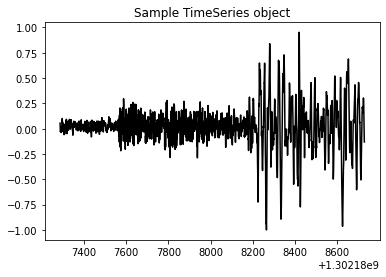

In [28]:
doc=dbh.wf_TimeSeries.find_one()
print('Metadata for what is plotted below')
print(json_util.dumps(doc,indent=2))
ts=dbh.read_data(doc)
plotter.title='Sample TimeSeries object'
plotter.plot(ts)

Metadata for what is plotted below
{
  "_id": {
    "$oid": "610b0bd4d9e953b77ae55624"
  },
  "orthogonal": false,
  "time_standard": "UTC",
  "starttime": 1302187287.1,
  "delta": 0.025,
  "source_id": {
    "$oid": "610b0ba1d9e953b77ae54bfe"
  },
  "utc_convertible": true,
  "npts": 55566,
  "sampling_rate": 40.0,
  "format": "mseed",
  "site_id": {
    "$oid": "610b0baad9e953b77ae54c05"
  },
  "tmatrix": [
    0.0,
    0.0,
    1.0,
    0.00872653549840032,
    0.9999619230641711,
    2.6484540326036093e-14,
    0.9999619230641713,
    -0.008726535498373787,
    2.6484540326036093e-14
  ],
  "storage_mode": "gridfs",
  "dfile": "./wf/shortcourse_8.mseed",
  "cardinal": false,
  "foff": 0,
  "dir": "/home",
  "gridfs_id": {
    "$oid": "610b0bd4d9e953b77ae5561d"
  },
  "history_object_id": "7d0c147c-6e7f-4faf-a3e1-558617dd7578",
  "data_tag": "rawsample"
}


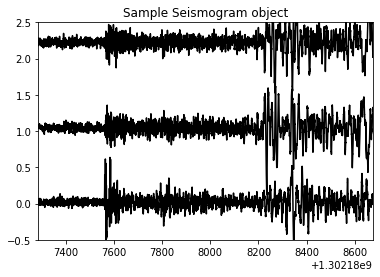

In [29]:
doc=dbh.wf_Seismogram.find_one()
print('Metadata for what is plotted below')
print(json_util.dumps(doc,indent=2))
d=dbh.read_data(doc,collection='wf_Seismogram')
plotter.title='Sample Seismogram object'
plotter.normalize=True
plotter.plot(d)

Discuss:
- Similarities and differences in Metadata
- How graphics define differences in the sample data
- Use of the *collection* argument to segregate *TimeSeries* and *Seismogram* data for read_data
- Scaling used in the plots

The final issue we want to cover is how we store the sample data and how you can access it?  The way we store *TimeSeries* sample data is the univeral method of a vector container illustrated in the next box:

In [29]:
# ts was loaded above
# Print just the first 10 samples or we get a huge box of text
print('Index Time(UTC)  amplitude')
for i in range(10):
    print(i,UTCDateTime(ts.time(i)),ts.data[i])

Index Time(UTC)  amplitude
0 2011-04-07T14:41:27.124998Z 627.0
1 2011-04-07T14:41:27.149998Z 666.0
2 2011-04-07T14:41:27.174998Z 649.0
3 2011-04-07T14:41:27.199998Z 647.0
4 2011-04-07T14:41:27.224998Z 649.0
5 2011-04-07T14:41:27.249998Z 653.0
6 2011-04-07T14:41:27.274998Z 681.0
7 2011-04-07T14:41:27.299998Z 633.0
8 2011-04-07T14:41:27.324998Z 674.0
9 2011-04-07T14:41:27.349998Z 688.0


**Discussion:**
- Is everyone familiar with that concept? 

- What is the incantation used to create the second column of output?

- How are vectors stored in the computer?

*Seismogram* data require a different approach.  We note seismic reflection systems never handle this uniformly because 3C data is always treated as special data.  In the world of seismology that is not at all true and today 3C data is the norm.  Our implementation:
- Stores Seismogram sample data in a matrix
- The matrix is 3Xnpts so the rows are component numbers and the columns are the time index
- The actual storage is a contiguous memory block 3*npts in what numpy calls FORTRAN order.

The python bindings for these data objects provide a simple subscripting method to access individual samples.  The following box illustrates this for both data types by altering a copy of the data by a simple scaling operation - multiply by 2:

In [30]:
from mspasspy.ccore.seismic import Seismogram,TimeSeries
# First scaling of TimeSeries samples
tscopy=TimeSeries(ts)
for i in range(ts.npts):
    tscopy.data[i] *= 2.0
# Only print 15 lines or we get a very verbose output
print('TimeSeries sample manipulation example:')
print('Original Scaled')
for i in range(15):
    print(ts.data[i],tscopy.data[i])
# Same operation for 3C data  
dcopy=Seismogram(d)
for j in range(d.npts):
    for i in range(3):
        dcopy.data[i,j] *= 2.0
print("\nSeismogram sample manipulation example")
print('Original 3C samples    Scaled 3C samples')
for i in range(15):
    # Messy format line to make the output a bit more readable
    s='{x1},{x2},{x3}     {xc1},{xc2},{xc3}'.format(x1=d.data[0,i],x2=d.data[1,i],x3=d.data[2,i],
                                    xc1=dcopy.data[0,i],xc2=dcopy.data[1,i],xc3=dcopy.data[2,i])
    print(s)

TimeSeries sample manipulation example:
Original Scaled
681.0 1362.0
678.0 1356.0
667.0 1334.0
653.0 1306.0
643.0 1286.0
630.0 1260.0
615.0 1230.0
600.0 1200.0
585.0 1170.0
570.0 1140.0
554.0 1108.0
541.0 1082.0
525.0 1050.0
501.0 1002.0
490.0 980.0

Seismogram sample manipulation example
Original 3C samples    Scaled 3C samples
269.0,936.0,3720.0     538.0,1872.0,7440.0
373.0,919.0,3702.0     746.0,1838.0,7404.0
504.0,864.0,3695.0     1008.0,1728.0,7390.0
573.0,828.0,3733.0     1146.0,1656.0,7466.0
618.0,799.0,3768.0     1236.0,1598.0,7536.0
626.0,746.0,3778.0     1252.0,1492.0,7556.0
592.0,724.0,3790.0     1184.0,1448.0,7580.0
576.0,729.0,3742.0     1152.0,1458.0,7484.0
527.0,759.0,3666.0     1054.0,1518.0,7332.0
459.0,788.0,3593.0     918.0,1576.0,7186.0
471.0,777.0,3475.0     942.0,1554.0,6950.0
585.0,743.0,3411.0     1170.0,1486.0,6822.0
690.0,739.0,3383.0     1380.0,1478.0,6766.0
718.0,740.0,3381.0     1436.0,1480.0,6762.0
784.0,730.0,3408.0     1568.0,1460.0,6816.0


**Discussion:**
- What is problematic about the approach used above for scaling?
- Why?

Consider the following:

In [31]:
import numpy as np
from scipy import signal
# Direct construct using max method of np.array
ampmax=np.array(ts.data).max()
print("maximum amplitude of data in ts=",ampmax)
# application of a typical scipy vector operator
smoother=np.array([0.25,0.25,0.25,0.25])
x=signal.convolve(ts.data,smoother)
print('First 20 samples of before and after smoother ')
for i in range(20):
    print(ts.data[i],x[i])

maximum amplitude of data in ts= 11411.0
First 20 samples of before and after smoother 
627.0 156.75
666.0 323.25
649.0 485.5
647.0 647.25
649.0 652.75
653.0 649.5
681.0 657.5
633.0 654.0
674.0 660.25
688.0 669.0
647.0 660.5
692.0 675.25
667.0 673.5
661.0 666.75
702.0 680.5
688.0 679.5
680.0 682.75
702.0 693.0
699.0 692.25
703.0 696.0


These examples illustrate:
- Partial equivalence in our bindings between numpy arrays and the vector where data is stored in the TimeSeries object
- An example of how the sample data can be handled with numpy
- An example of how the data can be passed as a vector to a processing function (scipy example)

Note in closing this section that the sample data in a Seismogram can be handled similarly provided it is treated as a matrix in "Fortran" order.  

## Data Object Design Discussion
We will close this session with some additional details about the data objects in MsPASS and a discussion of how similarities and differences with other implementations.  

First a few key points about the MsPASS data objects:
- Originated from concepts Pavlis developed about 15 years ago (SEISPP in antelope contrib)
- It would be fair to call the current implementation version 3 of the ideas
- Core code base is written in C++ exposed to python through pybind11; important for speed and efficiency
- pybind11 provided a clean mechanism to expose data arrays in the data object to python libraries.  e.g. most numpy and scipy functions can be directly applied directly to data arrays as we just saw.
- For more details see the following page in the User's Manual:  https://www.mspass.org/user_manual/data_object_design_concepts.html

There are two classes of data objects in MsPASS:
1.  We have repeatedly referred to *TimeSeries* and *Seismogram* objects.   In our documentation we frequently refer to both as "Atomic".   The reason is they are the basic building blocks of a data set.
2.  We have "Ensembles" that are groupings of the atomic objects.  Their names are consistent and (hopefully) fairly clear:  *TimeSeriesEnsemble* and *SeismogramEnsemble*.   

You as a user need to understand the difference and how they should be handled.  First, consider the atomic objects.  One might think of the atoms as being made of of subatomic particles defined in the following figure:

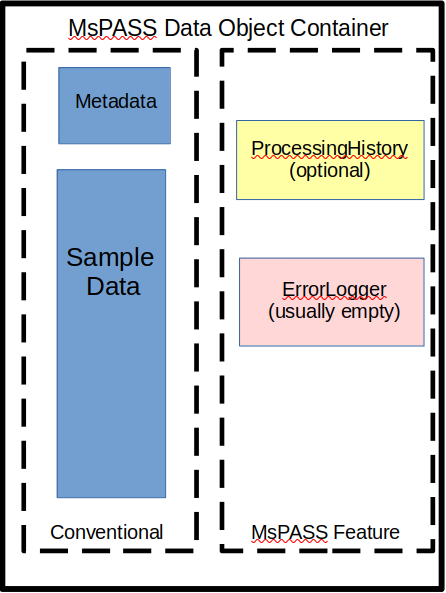


Let's discuss and make sure all understand what each of the following four pieces (subatomic) particle are:
1.  Metadata - accessible via dict-like syntax or getters and putters (see MsPASS User's Manuals and other tutorials)
2.  Sample data container - accessible by symbol *data*
3.  Error logger - accessible by symbol *elog*
4.  Object-level History container - accessible via separate API (see User Manual)


## Homework exercises
1. Read and plot a subset of waveforms from wf_Timeseries using read_ensemble_data and MongoDB cursor produced by a query.  For some queries (e.g. Z channels) you might want to use the limit method to make the plot readable in this notebook. 
2.  Read the entire raw data from the wf_Seismogram collection as a SeismogramEnsemble using *read_ensemble_data*, filter it as you choose, and save the results (with a unique *data_tag*) with *save_ensemble_data*.
3.  Build an index for the wf_TimeSeries collection using net:sta:chan.  
4.  Write a processing function that manipulates the sample data in python and saves the result with a unique tag.  You might want to then experiment with plotting functions to see what your function did.  e.g. a before and after plot of the same data.
5.  Write a processing function that applies a numpy or scipy function to the sample data.  Save and plot the data as in 4. 